<a href="https://colab.research.google.com/github/KushalTrivedi19032005/DAA-MAJOR/blob/main/IFNDipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Choose your GPU in runtime, run this cell, then restart runtime, and run all the following cells in order


In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
!pip install focal_loss_torch

Configuration

In [ ]:
BATCH_SIZE = 2
EPOCHS = 2
LEARNING_RATE = 2e-5

CSV_PATH = "/content/tokenized (1).csv"
IMAGE_ZIP_PATH = "/content/resized_images.zip"
IMAGE_DIR = "/content/sample_data/images"

**IMPORTS**

In [ ]:
import os
import zipfile
import pandas as pd
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
# from transformers import DistilBertTokenizer
from transformers.models.distilbert import DistilBertModel, DistilBertTokenizer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

**DATA LOADING**

In [ ]:
import os
import zipfile
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.preprocessing import OneHotEncoder
from transformers import DistilBertTokenizer

class NewsDataset(Dataset):
    def __init__(self, csv_path, image_zip_path, image_dir, transform=None,
                 tokenizer_name='distilbert-base-uncased', max_length=512):
        self.csv_path = csv_path
        self.image_zip_path = image_zip_path
        self.image_dir = image_dir
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length

        # Extract images from zip if not already extracted
        if not os.path.exists(self.image_dir):
            with zipfile.ZipFile(self.image_zip_path, 'r') as zip_ref:
                zip_ref.extractall(self.image_dir)

        # Load and clean the dataframe
        self.df = pd.read_csv(self.csv_path, usecols=['id', 'Statement', 'Web', 'Category', 'Date', 'Label'])
        self.df.dropna(subset=['Statement'], inplace=True)

        # Use new scikit-learn API
        self.web_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

        # Fit and transform metadata
        self.web_encoded = self.web_encoder.fit_transform(self.df[['Web']])
        self.cat_encoded = self.cat_encoder.fit_transform(self.df[['Category']])

# Assign unique column names to prevent index overlap
        web_df = pd.DataFrame(self.web_encoded, columns=[f'web_{i}' for i in range(self.web_encoded.shape[1])])
        cat_df = pd.DataFrame(self.cat_encoded, columns=[f'cat_{i}' for i in range(self.cat_encoded.shape[1])])

# Concatenate metadata features
        meta_df = pd.concat([web_df, cat_df], axis=1)

# Convert to torch tensor
        self.meta_features = torch.tensor(meta_df.values, dtype=torch.float32)

        self.meta_dim = self.meta_features.shape[1]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Text encoding
        encoded = self.tokenizer(
            row['Statement'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Image loading
        img_path = os.path.join(self.image_dir, f"img_{row['id']}.jpg")
        try:
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
        except FileNotFoundError:
            image = torch.zeros(3, 224, 224)

        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'image': image,
            'label': int(row['Label']),
            'id': int(row['id']),
            'meta': self.meta_features[idx]
        }


**TEXT ENCODER**

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

**IMAGE ENCODER**

In [ ]:
class ResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-1])

    def forward(self, x):
        x = self.feature_extractor(x).squeeze(-1).squeeze(-1)
        return x


**ATTENTION FUSION**

In [ ]:
import torch
import torch.nn as nn

class SimpleAttentionFusion(nn.Module):
    def __init__(self, text_dim=768, image_dim=2048, meta_dim=10, fusion_dim=512):
        super(SimpleAttentionFusion, self).__init__()

        # Project each modality to the same fusion dimension
        self.text_proj = nn.Linear(text_dim, fusion_dim)
        self.image_proj = nn.Linear(image_dim, fusion_dim)
        self.meta_proj = nn.Linear(meta_dim, fusion_dim)

        # Attention network to compute weights for each modality
        self.attn = nn.Linear(fusion_dim, 1)

    def forward(self, text_feat, image_feat, meta_feat):
        # Project individual modality features to fusion dimension
        text_feat = self.text_proj(text_feat)       # (batch_size, fusion_dim)
        image_feat = self.image_proj(image_feat)    # (batch_size, fusion_dim)
        meta_feat = self.meta_proj(meta_feat)       # (batch_size, fusion_dim)

        # Stack modality features for attention
        x = torch.stack([text_feat, image_feat, meta_feat], dim=1)  # (batch_size, 3, fusion_dim)

        # Compute attention weights
        attn_weights = torch.softmax(self.attn(x), dim=1)           # (batch_size, 3, 1)

        # Apply attention weights to features
        fused = torch.sum(attn_weights * x, dim=1)                  # (batch_size, fusion_dim)

        return fused


**MLP REDUCER**

In [ ]:
class MLPReducer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)

**ANFIS CLASSIFIER**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import product

class ANFISClassifier(nn.Module):
    def __init__(self, n_inputs, n_mfs):
        super(ANFISClassifier, self).__init__()
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.n_rules = n_mfs ** n_inputs

        # Gaussian MF parameters: centers (c) and sigmas for each MF
        self.c = nn.Parameter(torch.randn(n_inputs, n_mfs))       # (n_inputs, n_mfs)
        self.sigma = nn.Parameter(torch.rand(n_inputs, n_mfs))    # (n_inputs, n_mfs)

        # Consequent layer: one linear function per rule (n_inputs + 1 for bias)
        self.rule_params = nn.Parameter(torch.randn(self.n_rules, n_inputs + 1))  # (n_rules, n_inputs+1)

        # Precompute MF index combinations for all rules
        self.rule_indices = self._compute_rule_indices()

    def _compute_rule_indices(self):
        # Cartesian product of MF indices for each input feature (n_mfs^n_inputs combinations)
        return torch.tensor(list(product(range(self.n_mfs), repeat=self.n_inputs)), dtype=torch.long)

    def gaussian_mf(self, x, c, sigma):
        # Gaussian Membership Function
        return torch.exp(-((x - c)**2) / (2 * sigma**2 + 1e-6))

    def forward(self, x):
        batch_size = x.size(0)

        # Compute MF values: shape (batch, n_inputs, n_mfs)
        mf_values = []
        for i in range(self.n_inputs):
            x_i = x[:, i].unsqueeze(1)                           # (batch, 1)
            c_i = self.c[i].unsqueeze(0)                         # (1, n_mfs)
            sigma_i = self.sigma[i].unsqueeze(0)                 # (1, n_mfs)
            mf = self.gaussian_mf(x_i, c_i, sigma_i)             # (batch, n_mfs)
            mf_values.append(mf)
        mf_values = torch.stack(mf_values, dim=1)                # (batch, n_inputs, n_mfs)

        # Compute firing strength of each rule: shape (batch, n_rules)
        rule_strengths = []
        for rule in self.rule_indices:
            selected = mf_values[:, torch.arange(self.n_inputs), rule]  # (batch, n_inputs)
            strength = torch.prod(selected, dim=1)                       # (batch,)
            rule_strengths.append(strength)
        w = torch.stack(rule_strengths, dim=1)                    # (batch, n_rules)

        # Normalize firing strengths
        normalized_w = w / (w.sum(dim=1, keepdim=True) + 1e-6)    # (batch, n_rules)

        # Compute rule outputs: z_i = a1*x1 + a2*x2 + ... + an*xn + b
        x_extended = torch.cat([x, torch.ones(batch_size, 1, device=x.device)], dim=1)  # (batch, n_inputs + 1)
        z = torch.matmul(x_extended, self.rule_params.T)          # (batch, n_rules)

        # Final output: weighted sum of rule outputs
        output = (normalized_w * z).sum(dim=1)                    # (batch,)

        return torch.sigmoid(output).unsqueeze(1)  # Now returns shape (batch, 1)
         # Binary classification output


**FULL MODEL**

In [ ]:
import torch
import torch.nn as nn

class FakeNewsDetectionModel(nn.Module):
    def __init__(self, meta_dim):
        super(FakeNewsDetectionModel, self).__init__()
        self.text_encoder = TextEncoder()  # Outputs (batch_size, 768)
        self.image_encoder = ResNetEncoder()  # Outputs (batch_size, 2048)

        self.attn_fusion = SimpleAttentionFusion(
            text_dim=768,
            image_dim=2048,
            meta_dim=meta_dim,
            fusion_dim=512
        )  # Outputs (batch_size, 512)

        self.reducer = MLPReducer(input_dim=512, output_dim=4)  # Outputs (batch_size, 4)
        self.anfis = ANFISClassifier(n_inputs=4, n_mfs=3)       # Outputs (batch_size,)

    def forward(self, input_ids, attention_mask, images, metadata, return_image_feats=False):
        # Text features from transformer encoder
        text_feats = self.text_encoder(input_ids, attention_mask)  # (batch, 768)

        # Visual features from ResNet
        image_feats = self.image_encoder(images)                   # (batch, 2048)

        # Fused features using attention over text, image, metadata
        fused_feats = self.attn_fusion(text_feats, image_feats, metadata)  # (batch, 512)

        # Dimension reduction
        reduced_feats = self.reducer(fused_feats)  # (batch, 4)

        # ANFIS output
        out = self.anfis(reduced_feats)  # (batch,)

        if return_image_feats:
            return out, image_feats
        return out


**CUSTOM LOSS**

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, alpha_bce=0.5, beta_focal=2, gamma_huber=0.1, pos_weight=None, delta=0.1):
        super().__init__()
        self.alpha = alpha_bce
        self.beta = beta_focal
        self.gamma = gamma_huber
        self.delta = delta

        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.huber = nn.HuberLoss(delta=delta)

    def focal_loss(self, probs, targets, gamma=2):
        eps = 1e-8
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_term = (1 - p_t) ** gamma
        return -torch.mean(focal_term * torch.log(p_t + eps))

    def forward(self, logits, targets):
        targets = targets.view(-1, 1).float()
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        focal_loss = self.focal_loss(probs, targets)
        huber_loss = self.huber(probs, targets)
        total_loss = self.alpha * bce_loss + self.beta * focal_loss + self.gamma * huber_loss
        return total_loss, {
            "bce": bce_loss.item(),
            "focal": focal_loss.item(),
            "huber": huber_loss.item()
        }

In [ ]:
import matplotlib.pyplot as plt

# Tracking containers
train_loss_history = {"bce": [], "focal": [], "huber": []}
val_loss_history = {"bce": [], "focal": [], "huber": []}
val_accuracy_history = []


**TRAINING and EVALUATION**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize dataset and get meta_dim
dataset = NewsDataset(
    csv_path=CSV_PATH,
    image_zip_path=IMAGE_ZIP_PATH,
    image_dir=IMAGE_DIR
)
meta_dim = dataset.meta_dim

# Initialize model, loss, optimizer
model = FakeNewsDetectionModel(meta_dim=meta_dim).to(device)
pos_weight = torch.tensor([24.0], dtype=torch.float32).to(device)
criterion = CustomLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Helper: Stratified split
def stratified_split(dataset, test_size=0.2):
    labels = [int(dataset.df.iloc[i]['Label']) for i in range(len(dataset))]
    train_idx, test_idx = train_test_split(
        list(range(len(dataset))),
        test_size=test_size,
        stratify=labels,
        random_state=None
    )
    return Subset(dataset, train_idx), Subset(dataset, test_idx)

# Helper: Get DataLoaders
def get_dataloader(dataset, batch_size, test_size=0.2):
    train_set, test_set = stratified_split(dataset, test_size)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

# Helper: Evaluate model
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    loss_details = {"bce": 0.0, "focal": 0.0, "huber": 0.0}

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            metadata = batch['meta'].to(device)
            labels = batch['label'].to(device)

            outputs, _ = model(input_ids, attention_mask, images, metadata, return_image_feats=True)
            loss, details = criterion(outputs, labels)

            total_loss += loss.item()
            for key in loss_details:
                loss_details[key] += details[key]

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds.squeeze().long() == labels.long()).sum().item()
            total += labels.size(0)

    accuracy = correct / total if total > 0 else 0.0
    for key in loss_details:
        loss_details[key] /= len(dataloader)
    return total_loss, accuracy, loss_details

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    train_loader, test_loader = get_dataloader(dataset, BATCH_SIZE)

    total_loss = 0.0
    loss_details = {"bce": 0.0, "focal": 0.0, "huber": 0.0}

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        metadata = batch['meta'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs, _ = model(input_ids, attention_mask, images, metadata, return_image_feats=True)

        loss, details = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        for key in loss_details:
            loss_details[key] += details[key]

    for key in loss_details:
        train_loss_history[key].append(loss_details[key])
        val_loss_history[key].append(val_details[key])

    val_accuracy_history.append(val_acc)

    val_loss, val_acc, val_details = evaluate(model, test_loader, criterion, device)

print(f"Epoch [{epoch+1}/{EPOCHS}]")
print(f"  Train Loss: {total_loss:.4f} | BCE: {loss_details['bce']:.4f}, Focal: {loss_details['focal']:.4f}, Huber: {loss_details['huber']:.4f}")
print(f"  Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f} | BCE: {val_details['bce']:.4f}, Focal: {val_details['focal']:.4f}, Huber: {val_details['huber']:.4f}")
print(f"  Val Accuracy: {val_acc:.4f}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 46.0MB/s]
Epoch 1/2: 100%|██████████| 10640/10640 [31:05<00:00,  5.70it/s]


NameError: name 'val_details' is not defined

In [ ]:
def plot_losses(train_losses, val_losses, accuracy, epochs):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    loss_names = ["bce", "focal", "huber"]
    for i, loss_type in enumerate(loss_names):
        axs[i].plot(range(1, epochs+1), train_losses[loss_type], label='Train')
        axs[i].plot(range(1, epochs+1), val_losses[loss_type], label='Val')
        axs[i].set_title(f"{loss_type.upper()} Loss")
        axs[i].set_xlabel("Epoch")
        axs[i].set_ylabel("Loss")
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

    # Plot accuracy separately
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, epochs+1), accuracy, marker='o', color='green')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()


ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

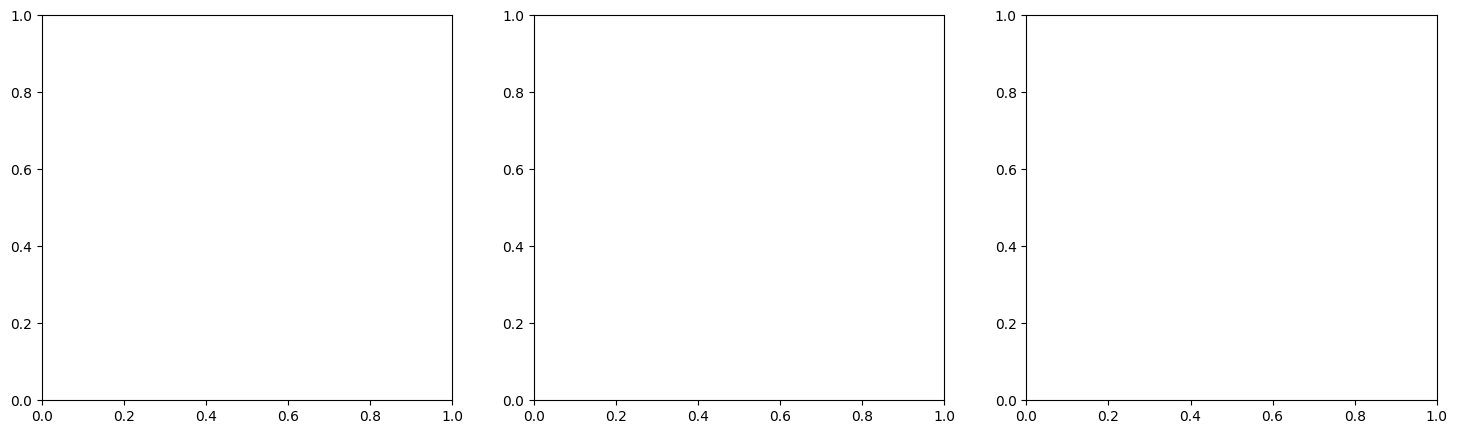

In [ ]:
plot_losses(train_loss_history, val_loss_history, val_accuracy_history, EPOCHS)

NameError: name 'np' is not defined